In [1]:
import pandas as pd
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy # need to conda install -c conda-forge spacy-model-en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerholston/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
IEPs = pd.read_csv('data/training_accommodation_data.csv')
IEPs.head(5)

,name,grade,disability,accommodation
0,Eric Chang,5,developmental delay,Large print textbooks
1,Jon Steele,2,developmental delay,Review of directions
2,Jacob Reyes,4,developmental delay,Review sessions
3,Joshua Hines,2,developmental delay,Study sheets and teacher outlines
4,Cheryl Turner,2,developmental delay,Quiet corner or room to calm down and relax wh...


In [3]:
# Tokenize list of text
def preprocess_list(list_of_text):
	for row in list_of_text:
		yield(gensim.utils.simple_preprocess(str(row), deacc=True)) # deacc removes punctuation

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [ bigram_mod[doc] for doc in texts ]

def make_trigrams(texts, bigram_mod, trigram_mod):
    return [ trigram_mod[bigram_mod[doc]] for doc in texts ]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []        
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([ token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return texts_out

In [4]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [5]:
def best_num_topics(list_of_text, min_count=3, threshold=10, start=4, limit=50, step=2):
	preprocessed_text = list(preprocess_list(list_of_text))
	
	bigram_text = gensim.models.Phrases(preprocessed_text, min_count=min_count, threshold=threshold) # higher threshold fewer phrases.
	trigram_text = gensim.models.Phrases(bigram_text[preprocessed_text], threshold=threshold)  
	bigram_mod_text = gensim.models.phrases.Phraser(bigram_text)
	trigram_mod_text = gensim.models.phrases.Phraser(trigram_text)

	preprocessed_nostops_text = remove_stopwords(preprocessed_text)

	form_trigram_text = make_trigrams(preprocessed_nostops_text, bigram_mod_text, trigram_mod_text)

	data_lemmatized_text = lemmatization(form_trigram_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

	# Create Dictionary
	id_to_word = corpora.Dictionary(data_lemmatized_text)

	# Term Document Frequency
	corpus = [ id_to_word.doc2bow(text) for text in data_lemmatized_text ]

	model_list, coherence_values = compute_coherence_values(dictionary=id_to_word, corpus=corpus, texts=data_lemmatized_text, start=start, limit=limit, step=step)
	return model_list, coherence_values, corpus

## Accommodation Model

In [28]:
accommodation_list = IEPs.accommodation.values.tolist()

model_list, coherence_values, corpus = best_num_topics(accommodation_list, start=16, limit=17) # can tune the params here

[0.4407276674221313, 0.46775383520037644, 0.47193990261744523, 0.5345140569118256, 0.5042826965791272, 0.466313311145137, 0.4626967325831609, 0.4400453616923633, 0.4322564204766673, 0.4208902258606748, 0.4300283068085415, 0.42692741076696916, 0.4366264558512302, 0.43993926483301016, 0.46202264027952894, 0.46704530729174226, 0.449106455860447, 0.46512746719026216, 0.4646650023245445, 0.46236906992068194, 0.47540688188771174, 0.4578233624029217, 0.4773549440651994]


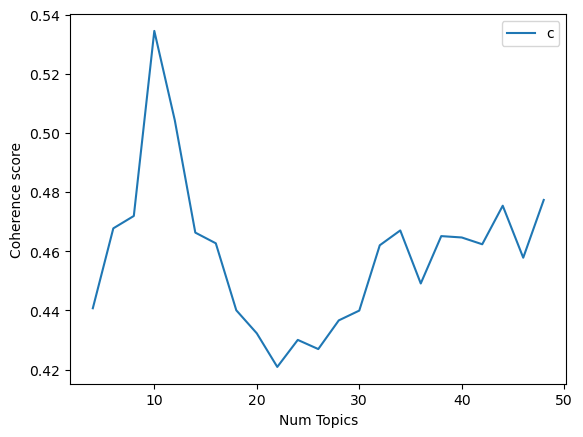

In [52]:
# Show graph
print(coherence_values)
plt.plot(list(range(4, 50, 2)), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
select_accommodation_model : gensim.models.LdaModel = model_list[0] # 16 topic was best

pyLDAvis.enable_notebook()
vis_accommodations = pyLDAvis.gensim_models.prepare(select_accommodation_model, corpus, select_accommodation_model.id2word, mds="mmds")
vis_accommodations

/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.162731  0.414000       1        1  23.611606
6     -0.303613  0.128336       2        1   9.965047
1      0.065056  0.339501       3        1   9.511774
8      0.315666  0.235205       4        1   9.507148
13    -0.136256  0.193646       5        1   7.068373
11     0.170848 -0.363601       6        1   6.404855
0      0.063006  0.168308       7        1   5.876836
10    -0.282635 -0.202204       8        1   5.511784
12    -0.291255 -0.036365       9        1   4.873746
3      0.358119 -0.021046      10        1   4.808364
4      0.223946 -0.144440      11        1   3.398385
9     -0.093911 -0.062642      12        1   2.568669
7      0.118549 -0.055523      13        1   2.271387
15    -0.013141 -0.282149      14        1   1.808222
2     -0.080306 -0.193037      15        1   1.694622
5      0.048659 -0.117988      16        1   1.119182, topic_info=           Term        Freq       Total Category  logprob  loglift
32        allow  225.000000  225.000000  Default  30.0000  30.0000
31      provide  170.000000  170.000000  Default  29.0000  29.0000
47      student  394.000000  394.000000  Default  28.0000  28.0000
46         need   38.000000   38.000000  Default  27.0000  27.0000
96      support   45.000000   45.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
538        goal    0.036349    0.951017  Topic16  -7.1198   1.2282
482  reflection    0.036349    0.951478  Topic16  -7.1198   1.2277
472  evaluation    0.036349    0.951502  Topic16  -7.1198   1.2277
390     monitor    0.036349    0.953321  Topic16  -7.1198   1.2258
568    separate    0.036351    0.956101  Topic16  -7.1198   1.2229

[544 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
118       8  0.965094             ability
747       5  0.944869            academic
316      10  0.882746              accept
93        1  0.972156              access
130       9  0.737186          accessible
...     ...       ...                 ...
195      11  0.950946                work
468      16  0.741178           workspace
129      10  0.974176               write
569       6  0.908482             writing
34        6  0.903421  written_assignment

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 7, 2, 9, 14, 12, 1, 11, 13, 4, 5, 10, 8, 16, 3, 6])

Accommodation 16 topics
1.  Occupational therapy fine motor
2.  | fidgeting, visual aids, scheduling (timer, day, calendar, cue, designate) - ADHD related
3.  communication and speech with peers
4.  use of visual aids, manipulatives, graphic organizers, and pictures
5.  social emotional issues
6.  assignment/testing alternatives and assistance
7.  system routine plan structure consistent predictable - predictable, structured, and consistent learning environment
8.  language, vocabulary, and grammar related learning issues
9.  alternate modalities for syntehesizing reading and writing material
10. incorporating accessibility into the learning environment
11. quiet work environment
12. breaking assignments up, flexible deadlines
13. visual auditory kinesthetic learning
14. visual cues and experience learning
15. repeated cues to stay on task
16. anxiety and quiet work environments

model topic # -> pyldavis topic #
* 0 -> 7
* 1 -> 3
* 2 -> 15
* 3 -> 10
* 4 -> 11
* 5 -> 16
* 6 -> 2
* 7 -> 13
* 8 -> 4
* 9 -> 12
* 10 -> 8
* 11 -> 6
* 12 -> 9
* 13 -> 5
* 14 -> 1
* 15 -> 14


In [ ]:
pprint(select_accommodation_model.print_topics(num_topics=-1, num_words=20))

In [73]:
accommodation_topic_summaries = {
    0: "predictable, structured, and consistent learning environment", 
    1: "communication and speech with peers",
    2: "repeated cues to stay on task",
    3: "incorporating accessibility into the learning environment",
    4: "quiet work environment",
    5: "student anxiety and quiet work environment",
    6: "attention related issues like fidgeting, scheduling, and need for visual aids",
    7: "visual, auditory, kinesthetic learning",
    8: "use of visual aids, manipulatives, graphic organizers, and pictures",
    9: "breaking assignments up and flexible deadlines",
    10: "language, vocabulary, and grammar related learning issues",
    11: "assignment/testing alternatives and assistance",
    12: "alternate modalities for syntehesizing reading and writing material",
    13: "social emotion issues",
    14: "occupational therapy and fine motor",
    15: "visual cues and experience learning"
}

In [108]:
# Example Usage
new_accommodation = "Allowing the student to have extra time for verbal or written communication."
new_accommodation_tokens = gensim.utils.simple_preprocess(new_accommodation, deacc=True)
new_accommodation_bow = select_accommodation_model.id2word.doc2bow(new_accommodation_tokens)

topic_distribution = select_accommodation_model[new_accommodation_bow]

if not topic_distribution[0]:
    print("No topics found for the given document.")
else:
    print("Topic distribution: ")
    for topic_prob in topic_distribution[0]:
        print("Topic", topic_prob[0], "probability:", topic_prob[1], "summary:", accommodation_topic_summaries[topic_prob[0]])

Topic distribution: 
Topic 0 probability: 0.0149334865 summary: predictable, structured, and consistent learning environment
Topic 1 probability: 0.23493136 summary: communication and speech with peers
Topic 2 probability: 0.18755297 summary: ?
Topic 3 probability: 0.015064725 summary: incorporating accessibility into the learning environment
Topic 4 probability: 0.010081349 summary: quiet work environment
Topic 6 probability: 0.022058312 summary: attention related issues like fidgeting, scheduling, and need for visual aids
Topic 8 probability: 0.02698339 summary: use of visual aids, manipulatives, graphic organizers, and pictures
Topic 10 probability: 0.015218397 summary: language, vocabulary, and grammar related learning issues
Topic 11 probability: 0.019754793 summary: assignment/testing alternatives and assistance
Topic 12 probability: 0.011483566 summary: ?
Topic 13 probability: 0.017929634 summary: ?
Topic 14 probability: 0.39892668 summary: Allow use of assistive technology


## Lesson Plan Models

In [6]:
LPs = pd.read_csv('data/unique_lesson_plans_data.csv')

math_LPs = LPs[LPs['subject'] == "Math"]
ela_LPs = LPs[LPs['subject'] == "Reading & Writing"]

math_LPs.head(5)

,subject,min_grade,max_grade,overview,objectives_outcomes,comment
8,Math,K,K,Gather students together and tell them that to...,Students will be able to understand the math c...,NaN
22,Math,K,K,Introduce the concept of earthworms to your st...,Students will describe the differences between...,NaN
23,Math,K,K,Gather the students where they can see the int...,Students will be able to add numbers to five.,NaN
25,Math,K,K,Tell your students that they will be counting ...,Students will be able to count to 100 by ones ...,NaN
26,Math,K,K,Tell your students to stand up if they have br...,Students will be able to count and classify sh...,NaN


In [18]:
math_overview_list = math_LPs.overview.values.tolist()

model_list, coherence_values, corpus = best_num_topics(math_overview_list, start=24, limit=25) # can tune the params here

[0.4188568086719437]


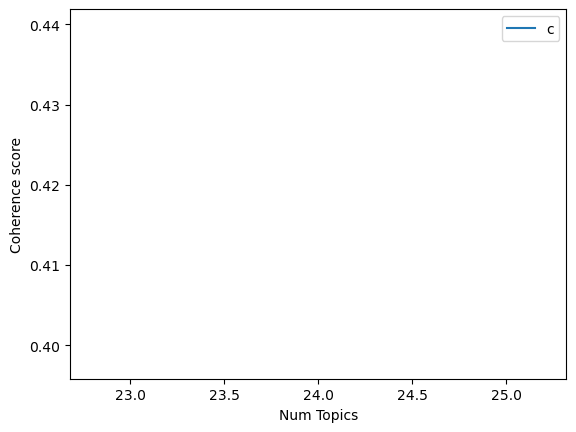

In [19]:
# Show graph
print(coherence_values)
plt.plot(list(range(24, 25, 2)), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
select_math_overview_model : gensim.models.LdaModel = model_list[0] # chose 24 topics

pyLDAvis.enable_notebook()
vis_accommodations = pyLDAvis.gensim_models.prepare(select_math_overview_model, corpus, select_math_overview_model.id2word, mds="mmds")
vis_accommodations

/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.105238  0.480211       1        1  38.341024
23    -0.172769  0.401386       2        1  16.207926
12    -0.024510  0.405056       3        1   8.908776
20    -0.213084  0.242026       4        1   4.424729
16    -0.389851  0.034275       5        1   3.999549
1     -0.405287  0.193723       6        1   3.193342
7      0.402531 -0.087055       7        1   3.139909
0     -0.251217 -0.347134       8        1   2.726359
4      0.393573  0.106445       9        1   2.468268
6      0.249653  0.265535      10        1   2.426356
11     0.242427  0.125959      11        1   2.184008
17    -0.297437 -0.093759      12        1   1.839286
5      0.277160 -0.321911      13        1   1.712774
22    -0.002852 -0.353211      14        1   1.437745
14    -0.212676 -0.218387      15        1   1.366586
3      0.194428 -0.151864      16        1   1.023366
19    -0.021238  0.114007      17        1   0.999417
9      0.091874 -0.260106      18        1   0.891856
8     -0.128021 -0.052363      19        1   0.810657
15    -0.034964 -0.197314      20        1   0.585423
13     0.142378 -0.063431      21        1   0.567713
21     0.027478 -0.030944      22        1   0.307968
18     0.031173 -0.096100      23        1   0.253827
10    -0.004009 -0.095045      24        1   0.183137, topic_info=            Term         Freq        Total Category  logprob  loglift
261        solve   142.000000   142.000000  Default  30.0000  30.0000
8        student  1679.000000  1679.000000  Default  29.0000  29.0000
247        share   193.000000   193.000000  Default  28.0000  28.0000
517      problem   125.000000   125.000000  Default  27.0000  27.0000
5         number   467.000000   467.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
962       school     0.014229     0.879448  Topic24  -7.6869   2.1787
1017  expression     0.014229     0.879456  Topic24  -7.6869   2.1786
244         idea     0.014230    50.679983  Topic24  -7.6868  -1.8753
74         thing     0.014229    41.099548  Topic24  -7.6869  -1.6658
8        student     0.014229  1679.935898  Topic24  -7.6869  -5.3763

[1003 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
178       4  0.872423        able
178      16  0.062316        able
639       3  0.824624  accomplish
137       2  0.500365      action
501       4  0.915369    activate
...     ...       ...         ...
610      12  0.849310   would_nee
47        1  0.851694       write
47        2  0.116582       write
47        5  0.025907       write
47       17  0.003238       write

[816 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 24, 13, 21, 17, 2, 8, 1, 5, 7, 12, 18, 6, 23, 15, 4, 20, 10, 9, 16, 14, 22, 19, 11])

In [23]:
pprint(select_math_overview_model.print_topics(num_topics=-1, num_words=4))

[(0, '0.156*"shape" + 0.119*"line" + 0.066*"graph" + 0.064*"picture"'),
 (1, '0.261*"solve" + 0.230*"problem" + 0.085*"answer" + 0.044*"rectangle"'),
 (2, '0.201*"student" + 0.071*"number" + 0.056*"ask" + 0.049*"tell"'),
 (3, '0.103*"time" + 0.101*"also" + 0.054*"day" + 0.049*"meaning"'),
 (4, '0.117*"share" + 0.083*"turn" + 0.079*"piece" + 0.069*"idea"'),
 (5, '0.215*"area" + 0.117*"leave" + 0.094*"rule" + 0.063*"involve"'),
 (6, '0.150*"divide" + 0.110*"take" + 0.091*"place" + 0.050*"bar_graph"'),
 (7, '0.081*"compare" + 0.068*"great" + 0.064*"circle" + 0.061*"symbol"'),
 (8, '0.159*"square" + 0.107*"difference" + 0.095*"box" + 0.042*"even"'),
 (9, '0.244*"pattern" + 0.060*"pizza" + 0.036*"kind" + 0.029*"mark"'),
 (10, '0.122*"brainstorm" + 0.043*"egg" + 0.014*"enjoy" + 0.010*"spring"'),
 (11, '0.169*"count" + 0.085*"fruit" + 0.082*"right" + 0.059*"ten"'),
 (12, '0.088*"student" + 0.045*"question" + 0.043*"ask" + 0.042*"time"'),
 (13,
  '0.249*"subtract" + 0.222*"subtraction" + 0.014

Math overview 24 topics
1.  student participation and problem solving
2.  small group discussion and class review
3.  asking questions to the class
4.  measurement
5.  student engagement
6.  geometric problem solving
7.  comparing numbers and objects
8.  graphing and graph analysis
9.  area and geometric reasoning especially related to manipulatives
10. understanding graphing and relating to real world examples
11. number sense
12. story problems and building physical models to represent
13. place value and decimal arithmetic
14. !
15. geometry and arithmetic
16. understanding time
17. basic operations and fact families
18. counting and data collection
19. measurement and geometry
20. measurement and shape
21. learning subtraction
22. patterns and sequences
23. spatial reasoning
24. brainstorming and critical thinking

model topic # -> pyldavis topic #
0 -> 8
1 -> 6
2 -> 1
3 -> 16
4 -> 9
5 -> 13
6 -> 10
7 -> 7
8 -> 19
9 -> 18
10 -> 24
11 -> 11
12 -> 3
13 -> 21
14 -> 15
15 -> 20
16 -> 5
17 -> 12
18 -> 23
19 -> 17
20 -> 4
21 -> 22
22 -> 14
23 -> 2

In [ ]:
math_overview_topic_summaries = {
    0: 'graphing and graph analysis',
    1: 'geometric problem solving',
    2: 'student participation and problem solving',
    3: 'understanding time',
    4: 'area and geometric reasoning especially related to manipulatives',
    5: 'place value and decimal arithmetic',
    6: 'understanding graphing and relating to real world examples',
    7: 'comparing numbers and objects',
    8: 'measurement and geometry',
    9: 'counting and data collection',
    10: 'brainstorming and critical thinking',
    11: 'number sense',
    12: 'asking questions to the class',
    13: 'learning subtraction',
    14: 'geometry and arithmetic',
    15: 'measurement and shape',
    16: 'student engagement',
    17: 'story problems and building physical models to represent',
    18: 'spatial reasoning',
    19: 'basic operations and fact families',
    20: 'measurement',
    21: 'patterns and sequences',
    22: '',
    23: 'small group discussion and class review'
}

In [8]:
ela_overview_list = ela_LPs.overview.values.tolist()

model_list, coherence_values, corpus = best_num_topics(ela_overview_list, start=18, limit=19) # can tune the params here

[0.353149490870275, 0.40039166207515525, 0.37188226048563916, 0.39882770688512237, 0.3856369360991338, 0.36826548682436455, 0.39949931142767425, 0.44034443298346854, 0.3968061114844447, 0.38550022954279356, 0.4076508133510177, 0.39941665354734435, 0.4155569375201126, 0.4108374618982939, 0.4572224535732079, 0.42877500490872084, 0.42113329100547475, 0.42598774098208425, 0.4479559604986888, 0.44028341743031163, 0.448411709179536, 0.45178920328078226, 0.4085176998253875]


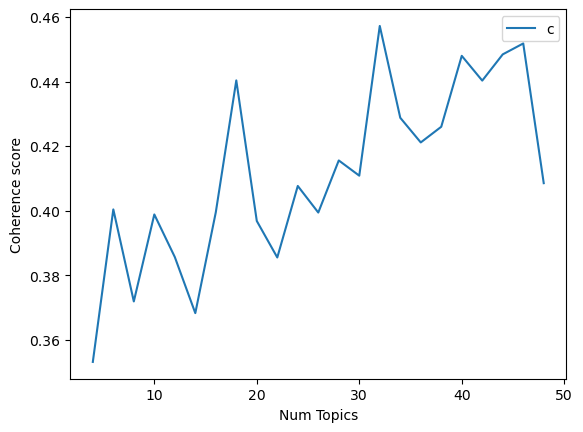

In [105]:
# Show graph
print(coherence_values)
plt.plot(list(range(18, 19, 2)), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
select_ela_overview_model : gensim.models.LdaModel = model_list[0] # 18 topics was best

pyLDAvis.enable_notebook()
vis_accommodations = pyLDAvis.gensim_models.prepare(select_ela_overview_model, corpus, select_ela_overview_model.id2word, mds="mmds")
vis_accommodations

/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.500913 -0.153114       1        1  43.754383
9      0.297999 -0.375747       2        1  16.864256
15    -0.207368 -0.444643       3        1  12.534752
0      0.023844 -0.366070       4        1   5.098436
13    -0.424678 -0.080247       5        1   4.139605
4     -0.373430  0.222779       6        1   3.346078
8      0.257257 -0.093791       7        1   2.521034
2     -0.198662 -0.149897       8        1   1.838424
3      0.199999  0.318720       9        1   1.565354
10    -0.007721  0.343988      10        1   1.362693
11    -0.159445  0.279543      11        1   1.247076
12    -0.222473  0.035344      12        1   1.204818
6      0.007895 -0.131983      13        1   1.112915
7      0.219345  0.096669      14        1   1.002924
17     0.136903  0.185138      15        1   0.886007
16     0.001774  0.172379      16        1   0.616521
14    -0.067605  0.085594      17        1   0.514674
5      0.015452  0.055339      18        1   0.390051, topic_info=             Term         Freq        Total Category  logprob  loglift
79           word   971.000000   971.000000  Default  30.0000  30.0000
168         story   357.000000   357.000000  Default  29.0000  29.0000
33           book   271.000000   271.000000  Default  28.0000  28.0000
30        student  3192.000000  3192.000000  Default  27.0000  27.0000
106      sentence   387.000000   387.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
929         skill     0.027780     0.925099  Topic18  -8.4256   2.0411
949         small     0.027776     0.924854  Topic18  -8.4258   2.0412
1831  observation     0.027777     0.925344  Topic18  -8.4257   2.0407
1263       phrase     0.027777     0.925782  Topic18  -8.4258   2.0402
779      response     0.027777     0.925890  Topic18  -8.4258   2.0401

[705 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
573      15  0.532906      achieve
481       2  0.983823       action
481       3  0.012945       action
666       2  0.992622  action_verb
648      11  0.836667     activate
...     ...       ...          ...
32        3  0.422633        write
474       4  0.937359         year
474       8  0.052076         year
344       5  0.947540    yesterday
495      18  0.504977          zoo

[548 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 16, 1, 14, 5, 9, 3, 4, 11, 12, 13, 7, 8, 18, 17, 15, 6])

In [24]:
pprint(select_ela_overview_model.print_topics(num_topics=-1, num_words=4))

[(0, '0.215*"story" + 0.096*"character" + 0.058*"need" + 0.056*"set"'),
 (1, '0.189*"student" + 0.055*"tell" + 0.055*"ask" + 0.047*"explain"'),
 (2, '0.135*"first" + 0.119*"noun" + 0.036*"different_kind" + 0.035*"prepare"'),
 (3, '0.117*"compare" + 0.092*"sometimes" + 0.078*"term" + 0.078*"inform"'),
 (4, '0.249*"book" + 0.130*"author" + 0.094*"information" + 0.077*"person"'),
 (5, '0.134*"experience" + 0.075*"favorite" + 0.037*"thumb" + 0.030*"memory"'),
 (6, '0.144*"image" + 0.102*"table" + 0.093*"form" + 0.056*"correct"'),
 (7, '0.128*"prompt" + 0.098*"well" + 0.091*"instruct" + 0.062*"syllable"'),
 (8, '0.134*"part" + 0.113*"meaning" + 0.103*"come" + 0.069*"figure"'),
 (9, '0.071*"student" + 0.067*"read" + 0.045*"give" + 0.041*"know"'),
 (10, '0.191*"piece" + 0.080*"object" + 0.048*"encourage" + 0.044*"walk"'),
 (11, '0.242*"dog" + 0.062*"line" + 0.033*"refer" + 0.031*"red"'),
 (12,
  '0.163*"change" + 0.110*"similar" + 0.079*"brainstorm" + 0.046*"remember"'),
 (13, '0.116*"time" +

Reading & Writing overview 18 topics
1.  developing abilities to share, explain, and discuss ideas related to a particular text
2.  comprehension and analysis, as well as asking and answering questions related to the text
3.  vocabulary, sentence structure, and phonological awareness
4.  analyze and understand story elements such as characters and setting
5.  analyze and compare texts, particularly in terms of how time and place
6.  analyze and interpret elements of a book such as the cover, illustrations, and layout
7.  understanding meaning, figures of speech, and sound devices such as rhyming words
8.  grammar conventions such as use of proper nouns, capitalization, and punctuation
9.  comparing and contrasting
10. analyze and compare different objects using prior knowledge
11. use descriptive language to express experiences and sensory perceptions of different objects
12. language features such as vowel sounds, rhymes, tense, and silent letters
13. non-fiction text features and using diagrams or charts to analyze text
14. follow writing prompts, identify and use syllables, and make connections between different ideas or concepts
15. organize and contribute to community issues either verbally or writen
16. identify vowels and consonants and understand their purpose in the sounds and structures of words
17. ! identify and analyze different themes and traditions (valentines day)
18. ! (silent letters, memory, favorite, experience)

model topic # -> pyldavis topic #
0 -> 4
1 -> 1
2 -> 8
3 -> 9
4 -> 6
5 -> 18
6 -> 13
7 -> 14
8 -> 7
9 -> 2
10 -> 10
11 -> 11
12 -> 12
13 -> 5
14 -> 17
15 -> 3
16 -> 16
17 -> 15

In [ ]:
ela_overview_topic_summaries = {
    0: 'analyze and understand story elements such as characters and setting',
    1: 'developing abilities to share, explain, and discuss ideas related to a particular text',
    2: 'grammar conventions such as use of proper nouns, capitalization, and punctuation',
    3: 'comparing and contrasting',
    4: 'analyze and interpret elements of a book such as the cover, illustrations, and layout',
    5: '',
    6: 'non-fiction text features and using diagrams or charts to analyze text',
    7: 'follow writing prompts, identify and use syllables, and make connections between different ideas or concepts',
    8: 'understanding meaning, figures of speech, and sound devices such as rhyming words',
    9: 'comprehension and analysis, as well as asking and answering questions related to the text',
    10: 'analyze and compare different objects using prior knowledge',
    11: 'use descriptive language to express experiences and sensory perceptions of different objects',
    12: 'language features such as vowel sounds, rhymes, tense, and silent letters',
    13: 'analyze and compare texts, particularly in terms of how time and place',
    14: '',
    15: 'vocabulary, sentence structure, and phonological awareness',
    16: 'identify vowels and consonants and understand their purpose in the sounds and structures of words',
    17: 'organize and contribute to community issues either verbally or writen'
}

In [10]:
math_objective_list = math_LPs.objectives_outcomes.values.tolist()

model_list, coherence_values, corpus = best_num_topics(math_objective_list) # can tune the params here

[0.5046621514494498, 0.47043798445584256, 0.41265646691138025, 0.42221929214014436, 0.42995212567709995, 0.49074131905592183, 0.4545093035745557, 0.4255620255159002, 0.4498677968006163, 0.46149878346979367, 0.4814213572394023, 0.4725234164451036, 0.4593468518181205, 0.48079452773881265, 0.5040774098319616, 0.4672278214212415, 0.5175443106917396, 0.5260630016290989, 0.511396106401377, 0.5238152041503097, 0.5296791171356269, 0.5330387380620373, 0.5252241446815072]


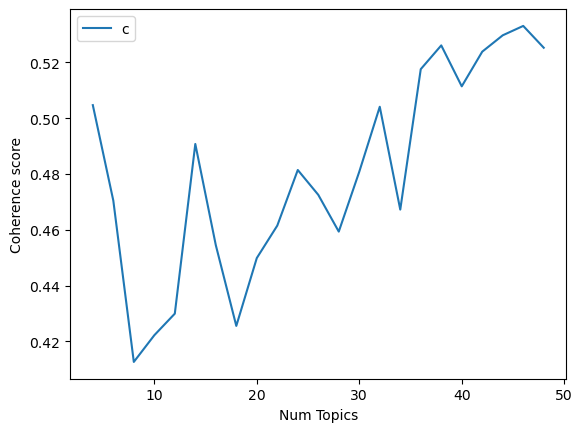

In [12]:
# Show graph
print(coherence_values)
plt.plot(list(range(4, 50, 2)), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
select_math_objective_model : gensim.models.LdaModel = model_list[5]

pyLDAvis.enable_notebook()
vis_accommodations = pyLDAvis.gensim_models.prepare(select_math_objective_model, corpus, select_math_objective_model.id2word, mds="mmds")
vis_accommodations

/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.057973  0.377845       1        1  25.787139
6     -0.269160  0.237614       2        1  25.719529
5     -0.123940  0.307304       3        1  21.518112
4     -0.378615 -0.028279       4        1   8.675385
11     0.186311  0.199394       5        1   7.857553
1      0.319894  0.007486       6        1   3.711173
13    -0.129620 -0.144452       7        1   2.070598
9      0.027914 -0.267862       8        1   2.018957
7      0.201946 -0.186515       9        1   1.603281
12     0.008241 -0.132397      10        1   0.370279
10     0.024637 -0.093252      11        1   0.185183
8      0.024806 -0.092295      12        1   0.160937
0      0.024807 -0.092296      13        1   0.160937
3      0.024805 -0.092295      14        1   0.160937, topic_info=         Term        Freq       Total Category  logprob  loglift
5      number  116.000000  116.000000  Default  30.0000  30.0000
151     solve   85.000000   85.000000  Default  29.0000  29.0000
42        use  104.000000  104.000000  Default  28.0000  28.0000
214  fraction   66.000000   66.000000  Default  27.0000  27.0000
71     create   20.000000   20.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
25       cube    0.010995    1.044853  Topic14  -6.3869   1.8777
26   cylinder    0.010995    1.044853  Topic14  -6.3869   1.8777
27       name    0.010995    4.962555  Topic14  -6.3869   0.3196
28     relate    0.010995    1.044853  Topic14  -6.3869   1.8777
29     sphere    0.010995    1.044853  Topic14  -6.3869   1.8777

[629 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         1  0.437936          able
0         2  0.257049          able
0         3  0.214208          able
0         4  0.033321          able
0         5  0.052362          able
...     ...       ...           ...
100       2  0.822156          word
100       3  0.137026          word
220       4  0.989761  word_problem
16        2  0.752127          worm
94        2  0.992621         write

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 5, 12, 2, 14, 10, 8, 13, 11, 9, 1, 4])

In [25]:
pprint(select_math_objective_model.print_topics(num_topics=-1, num_words=4))

[(0, '0.002*"even" + 0.002*"denomination" + 0.002*"odd" + 0.002*"feature"'),
 (1,
  '0.084*"number_line" + 0.083*"problem" + 0.053*"form" + 0.053*"represent"'),
 (2, '0.178*"student" + 0.176*"able" + 0.089*"use" + 0.034*"model"'),
 (3, '0.002*"even" + 0.002*"denomination" + 0.002*"odd" + 0.002*"feature"'),
 (4,
  '0.143*"solve" + 0.087*"word_problem" + 0.067*"student" + 0.060*"addition"'),
 (5, '0.141*"student" + 0.103*"able" + 0.075*"fraction" + 0.043*"decimal"'),
 (6, '0.151*"student" + 0.111*"number" + 0.103*"able" + 0.040*"write"'),
 (7, '0.298*"create" + 0.089*"unit" + 0.034*"life" + 0.028*"picture"'),
 (8, '0.002*"even" + 0.002*"denomination" + 0.002*"odd" + 0.002*"feature"'),
 (9, '0.087*"practice" + 0.069*"fact" + 0.035*"gemda" + 0.035*"component"'),
 (10, '0.012*"look" + 0.002*"attribute" + 0.002*"object" + 0.002*"less"'),
 (11, '0.074*"student" + 0.069*"able" + 0.066*"subtract" + 0.043*"measure"'),
 (12, '0.085*"explore" + 0.065*"dividing" + 0.030*"guide" + 0.010*"movement"')

Math objective 14 topics
1. operations with whole numbers and basic geometry concepts
2. number sense, understanding of mathematical expressions, and recognizing patterns in numbers
3. understanding fractions, decimals, and operations involving these concepts
4. applying mathematical concepts to real-world scenarios and using equations, arrays, and graphs, to solve complex problems
5. solving word problems related to volume
6. read and interpret data represented in different forms, such as bar graphs, line graphs, or number lines
7. word problems related to measurement concepts (temperature, time, shape)
8. developing strategies for counting, order of operations, and grouping items for multiplication
9. using mathematical rules to solve problems and working with units of measurement
10. !
11. !
12. !
13. !
14. !

model topic # -> pyldavis topic #
0 -> 
1 -> 6
2 -> 1
3 -> 
4 -> 4
5 -> 3
6 -> 2
7 -> 9
8 -> 
9 -> 8
10 -> 
11 -> 5
12 -> 10
13 -> 7

In [ ]:
math_objective_topic_summaries = {
    0: '',
    1: 'read and interpret data represented in different forms, such as bar graphs, line graphs, or number lines',
    2: 'operations with whole numbers and basic geometry concepts',
    3: '',
    4: 'applying mathematical concepts to real-world scenarios and using equations, arrays, and graphs, to solve complex problems',
    5: 'understanding fractions, decimals, and operations involving these concepts',
    6: 'number sense, understanding of mathematical expressions, and recognizing patterns in numbers',
    7: 'using mathematical rules to solve problems and working with units of measurement',
    8: '',
    9: 'developing strategies for counting, order of operations, and grouping items for multiplication',
    10: '',
    11: 'solving word problems related to volume',
    12: '',
    13: 'ord problems related to measurement concepts (temperature, time, shape)'
}

In [14]:
ela_objective_list = ela_LPs.objectives_outcomes.values.tolist()

model_list, coherence_values, corpus = best_num_topics(ela_objective_list) # can tune the params here

[0.3406194829554439, 0.37829181593891775, 0.46973748696713763, 0.43415794608628466, 0.5245420412216945, 0.4568197281630482, 0.4375516096453689, 0.4481558269938613, 0.4532953929457607, 0.4352202638132914, 0.43633243923747794, 0.46064953261261266, 0.4342836873070922, 0.450234773407064, 0.47397261236746757, 0.44771554638441835, 0.4535493633935119, 0.47904431640756573, 0.45812826061201567, 0.4591644924828115, 0.47878190627818534, 0.474163668399702, 0.48032885930870145]


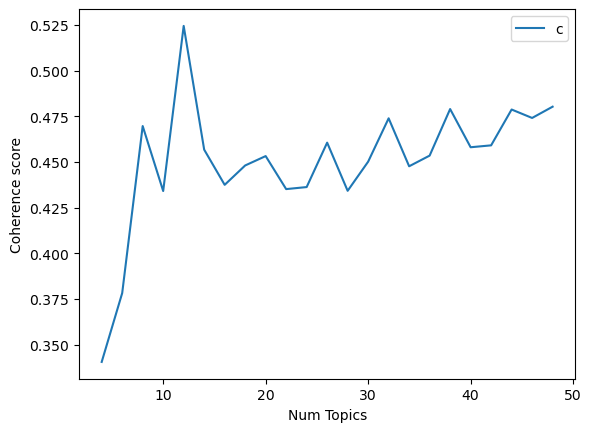

In [15]:
# Show graph
print(coherence_values)
plt.plot(list(range(4, 50, 2)), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
select_ela_objective_model : gensim.models.LdaModel = model_list[4]

pyLDAvis.enable_notebook()
vis_accommodations = pyLDAvis.gensim_models.prepare(select_ela_objective_model, corpus, select_ela_objective_model.id2word, mds="mmds")
vis_accommodations

/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/tylerholston/opt/anaconda3/envs/TreeHacks2023/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140937 -0.453040       1        1  44.443494
7     -0.136977 -0.354737       2        1  10.086939
1     -0.387025 -0.087501       3        1   7.639630
8     -0.268317  0.297260       4        1   7.379089
9      0.258885 -0.190598       5        1   6.624969
6      0.383401  0.002094       6        1   6.115714
2     -0.008348  0.386224       7        1   4.467916
5     -0.161933 -0.134107       8        1   4.066922
11    -0.212084  0.100032       9        1   3.142747
10     0.193963  0.289546      10        1   3.039381
4      0.196590  0.109578      11        1   2.739260
3      0.000911  0.035251      12        1   0.253939, topic_info=         Term         Freq        Total Category  logprob  loglift
3     student  1260.000000  1260.000000  Default   30.000  30.0000
7        able   889.000000   889.000000  Default   29.000  29.0000
6        word   198.000000   198.000000  Default   28.000  28.0000
35       text   124.000000   124.000000  Default   27.000  27.0000
117  sentence   105.000000   105.000000  Default   26.000  26.0000
..        ...          ...          ...      ...      ...      ...
1    identify     0.019424   337.385531  Topic12   -7.053  -3.7866
75    message     0.019424     4.437051  Topic12   -7.053   0.5446
7        able     0.019424   889.819641  Topic12   -7.053  -4.7564
63      sound     0.019424    16.375695  Topic12   -7.053  -0.7612
12      write     0.019424   185.360797  Topic12   -7.053  -3.1877

[442 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
834       8  0.942642    abbreviation
7         1  0.983345            able
7         2  0.005619            able
7         3  0.002248            able
7         5  0.003371            able
...     ...       ...             ...
933       2  0.844725  word_structure
347       7  0.965001            work
12        1  0.998054           write
312       3  0.867509         writing
312       8  0.104101         writing

[386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 2, 9, 10, 7, 3, 6, 12, 11, 5, 4])

In [26]:
pprint(select_ela_objective_model.print_topics(num_topics=-1, num_words=4))

[(0, '0.311*"student" + 0.223*"able" + 0.083*"identify" + 0.047*"write"'),
 (1, '0.155*"sentence" + 0.072*"read" + 0.040*"correctly" + 0.037*"writing"'),
 (2, '0.075*"create" + 0.062*"form" + 0.043*"work" + 0.042*"irregular_verb"'),
 (3,
  '0.022*"recall" + 0.014*"lowercase_letter" + 0.014*"uppercase" + '
  '0.008*"inferential"'),
 (4, '0.184*"evidence" + 0.053*"article" + 0.050*"fact" + 0.037*"define"'),
 (5, '0.062*"make" + 0.055*"narrative" + 0.039*"base" + 0.037*"correspond"'),
 (6,
  '0.229*"text" + 0.048*"fiction" + 0.044*"point" + 0.034*"answer_question"'),
 (7, '0.222*"word" + 0.063*"context" + 0.046*"recognize" + 0.037*"different"'),
 (8,
  '0.073*"opinion" + 0.054*"character" + 0.048*"information" + '
  '0.047*"correct"'),
 (9,
  '0.063*"compare" + 0.050*"contrast" + 0.043*"feature" + 0.036*"knowledge"'),
 (10,
  '0.169*"understand" + 0.071*"homophone" + 0.065*"distinguish" + '
  '0.052*"idiom"'),
 (11,
  '0.146*"explain" + 0.078*"support" + 0.048*"source" + '
  '0.027*"chara

Reading & Writing objective 12 topics
1. understanding and identifying grammar such as parts of speech, conjunction, and word forms
2. vocabulary acquisition and comprehension, phonemic awareness, spelling, and figurative language
3. demonstrate command of the conventions of Standard English grammar and usage when writing or speaking
4. expressing analytical and critical thinking skills through reading and writing
5. analyzing, comparing, and contrasting different literary elements like characters, themes, and literature types
6. reading comprehension and critical thinking skills specifically regarding different types of text like fiction and non-fiction.
7. usage of various grammatical forms and structures
8. using proper pronunciation and identifying grammatical structures, patterns, and tenses
9. analyzing literary text including identifying and analyzing character traits and using text evidence
10. figurative language and its effects on communication
11. draw inferences and conclusions from the text, and evaluate main argument or claim with supporting evidence
12. developing basic literacy skills such as letter recognition and recall

model topic # -> pyldavis topic #
0 -> 1
1 -> 3
2 -> 7
3 -> 12
4 -> 11
5 -> 8
6 -> 6
7 -> 2
8 -> 4
9 -> 5
10 -> 10
11 -> 9

In [ ]:
ela_objective_topic_summaries = {
    0: 'understanding and identifying grammar such as parts of speech, conjunction, and word forms',
    1: 'demonstrate command of the conventions of Standard English grammar and usage when writing or speaking',
    2: 'usage of various grammatical forms and structures',
    3: 'developing basic literacy skills such as letter recognition and recall',
    4: 'draw inferences and conclusions from the text, and evaluate main argument or claim with supporting evidence',
    5: 'using proper pronunciation and identifying grammatical structures, patterns, and tenses',
    6: 'reading comprehension and critical thinking skills specifically regarding different types of text like fiction and non-fiction',
    7: 'usage of various grammatical forms and structures',
    8: 'expressing analytical and critical thinking skills through reading and writing',
    9: 'analyzing, comparing, and contrasting different literary elements like characters, themes, and literature types',
    10: 'figurative language and its effects on communication',
    11: 'analyzing literary text including identifying and analyzing character traits and using text evidence'
}

## Save Models

In [30]:
select_accommodation_model.save('accommodation_lda.model')
select_math_overview_model.save('math_overview_lda.model')
select_ela_overview_model.save('ela_overview_lda.model')
select_math_objective_model.save('math_objective_lda.model')
select_ela_objective_model.save('ela_objective_lda.model')